# One Particle

In [1]:
!python -V

Python 3.11.8


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#

import pickle
import pgzip
import os
import platform
import logging
import sys

from joblib import Parallel, delayed
N_JOBS=6
from tqdm.notebook import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots

In [3]:
use_cache = False
save_cache = False
save_debug = True 

datetime_init = datetime.now()

# os.makedirs('output/oneParticleSim', exist_ok=True)
output_prefix = "output/oneParticleSim/"+\
                datetime_init.strftime("%Y%m%d-%H%M%S") + "-" + \
                str("T" if save_debug else "F") + \
                str("T" if use_cache else "F") + \
                str("T" if save_cache else "F") + \
                "/"
output_ext = ".pgz.pkl"
os.makedirs(output_prefix, exist_ok=True)
print(output_prefix)

output/oneParticleSim/20240416-182134-TFF/


In [4]:
plt.set_loglevel("warning")

In [5]:
l = logging.getLogger()
l.setLevel(logging.NOTSET)
l_formatter = logging.Formatter('%(asctime)s - %(levelname)s - \n%(message)s')
l_file_handler = logging.FileHandler(f'{output_prefix}/logs.log', encoding='utf-8')
l_file_handler.setFormatter(l_formatter)
l.addHandler(l_file_handler)
l_console_handler = logging.StreamHandler(sys.stdout)
l_console_handler.setLevel(logging.INFO)
l_console_handler.setFormatter(logging.Formatter('%(message)s'))
l.addHandler(l_console_handler)

In [6]:
# if save_debug:
    # with open(output_prefix + "session_info.txt", "wt") as file:
s = ""
s += ("="*20 + "Session System Information" + "="*20) + "\n"
uname = platform.uname()
s +=  f"Python Version: {platform.python_version()}\n"
s +=  f"Platform: {platform.platform()}\n"
s += (f"System: {uname.system}")+ "\n"
s += (f"Node Name: {uname.node}")+ "\n"
s += (f"Release: {uname.release}")+ "\n"
s += (f"Version: {uname.version}")+ "\n"
s += (f"Machine: {uname.machine}")+ "\n"
s += (f"Processor: {uname.processor}")+ "\n"
s +=  f"CPU Counts: {os.cpu_count()} \n"
        # print(string)
        # file.write(string)
    # print(string)
l.info(s)

====================Session System Information====================
Python Version: 3.11.8
Platform: macOS-14.4.1-arm64-arm-64bit
System: Darwin
Node Name: TY-MB-A2485.local
Release: 23.4.0
Version: Darwin Kernel Version 23.4.0: Fri Mar 15 00:10:42 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T6000
Machine: arm64
Processor: arm
CPU Counts: 10 



In [7]:
l.info(f"""nthreads = {nthreads}
N_JOBS = {N_JOBS}""")

nthreads = 2
N_JOBS = 6


In [8]:
# np.show_config()

In [9]:
nx = 120+1
nz = 120+1
xmax = 20 #Micrometers
# zmax = (nz/nx)*xmax
zmax = 20
dt = 1e-4 # Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

pxmax = 2*pi*hb/dx/2
pzmax = 2*pi*hb/dz/2
# pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
# pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb

In [10]:
s = f"""nx = {nx}
nz = {nz} 
xmax = {xmax}
zmax = {zmax}
dt = {dt}
dx = {dx}
dz = {dz}
hb = {hb}
m3 = {m3}
m4 = {m4}
pxmax = {pxmax}
pymax = {pzmax}
"""
l.info(s)

nx = 121
nz = 121 
xmax = 20
zmax = 20
dt = 0.0001
dx = 0.3333333333333333
dz = 0.3333333333333333
hb = 63.5078
m3 = 3
m4 = 4
pxmax = 598.5469137769497
pymax = 598.5469137769497



In [11]:
l.info(f"""rotate phase per dt for m3 = {1j*hb*dt/(2*m3*dx*dz)} \t #want this to be small
rotate phase per dt for m4 = {1j*hb*dt/(2*m4*dx*dz)} 
number of grid points = {round(nx*nz/1000/1000,3)} (million)
minutes per grid op = {round((nx*nz)*0.001*0.001/60, 3)} \t(for 1μs/element_op)
""")

rotate phase per dt for m3 = 0.00952617j 	 #want this to be small
rotate phase per dt for m4 = 0.0071446275j 
number of grid points = 0.015 (million)
minutes per grid op = 0.0 	(for 1μs/element_op)



In [12]:
wavelength = 1.083 #Micrometers
beam_angle = 90
k = sin(beam_angle*pi/180/2) * 2*pi / wavelength # effective wavelength

#alternatively 
k = pi / (4*dx)
beam_angle = np.arcsin(k/(2*pi/wavelength))*180/pi

# print("k =", k, " is 45 degree Bragg")
# k = 2*pi / wavelength
# k = pi / (2*dz)
# k = pi / (4*dx)
# dopd = 60.1025 # 1/ms Doppler detuning (?)

p = hb*k
# print("k  =",k,"1/µm")
# print("p  =",p, "u*µm/ms")
v4 = hb*k/m4
v3 = hb*k/m3
# print("v3 =",v3, "µm/ms")
# print("v4 =",v4, "µm/ms")

# sanity check
# assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"
# dopd = 60.1025 # 1/ms Doppler detuning (?)
dopd = v3**2 * m3 / hb

In [13]:
l.info(f"""wavelength = {wavelength} µm
beam_angle = {beam_angle}
k = {k} 1/µm
p = {p} u*µm/ms
v3 = {v3} µm/ms
v4 = {v4} µm/ms
dopd = {dopd}
2*pi/(2*k)/dx = {2*pi/(2*k)/dx} this should be larger than 4 and bigger the better
""")
if not (pxmax > p*2.5): l.warning(f"p={p} not << pmax={pxmax} momentum resolution too small!")
if not 2*pi/(2*k)/dx > 1:  l.warning(f"2*pi/(2*k)/dx = {2*pi/(2*k)/dx} aliasing will happen")

wavelength = 1.083 µm
beam_angle = 23.96164465880665
k = 2.356194490192345 1/µm
p = 149.6367284442374 u*µm/ms
v3 = 49.87890948141247 µm/ms
v4 = 37.40918211105935 µm/ms
dopd = 117.52441169690678
2*pi/(2*k)/dx = 4.0 this should be larger than 4 and bigger the better



In [14]:
a4 = 0.007512 # scattering length µm
omega = 50 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

def VB(t, tauMid, tauPi):
    return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000
def VBF(t, tauMid, tauPi, V0FArg=V0F):
    return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

In [15]:
l.info(f"""a4 = {a4} µm
omega = {omega}
V0 = {V0}
tBraggPi = {tBraggPi}
tBraggCenter = {tBraggCenter}
tBraggEnd = {tBraggEnd}
""")

a4 = 0.007512 µm
omega = 50
V0 = 6350.780000000001
tBraggPi = 0.0031454037481358954
tBraggCenter = 0.01572701874067948
tBraggEnd = 0.03145403748135896



In [16]:
l.info(f"term infront of Bragg potential {1j*(dt/hb)}")
l.info(f"max(V) {1j*(dt/hb)*V(tBraggCenter)}")

term infront of Bragg potential 1.5746097329776815e-06j
max(V) 1.2683340910935947j


In [17]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)
zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)
cosGrid = np.cos(2*k*xgrid)

In [18]:
if abs(dx - (xlin[1]-xlin[0])) > 0.0001: l.error("AHHHHx")
if abs(dz - (zlin[1]-zlin[0])) > 0.0001: l.error("AHHHHz")

In [19]:
l.info(f"{round(psi.nbytes/1000/1000 ,3)} MB of data used to store psi")

0.234 MB of data used to store psi


max(V) 0.03140891988082037j


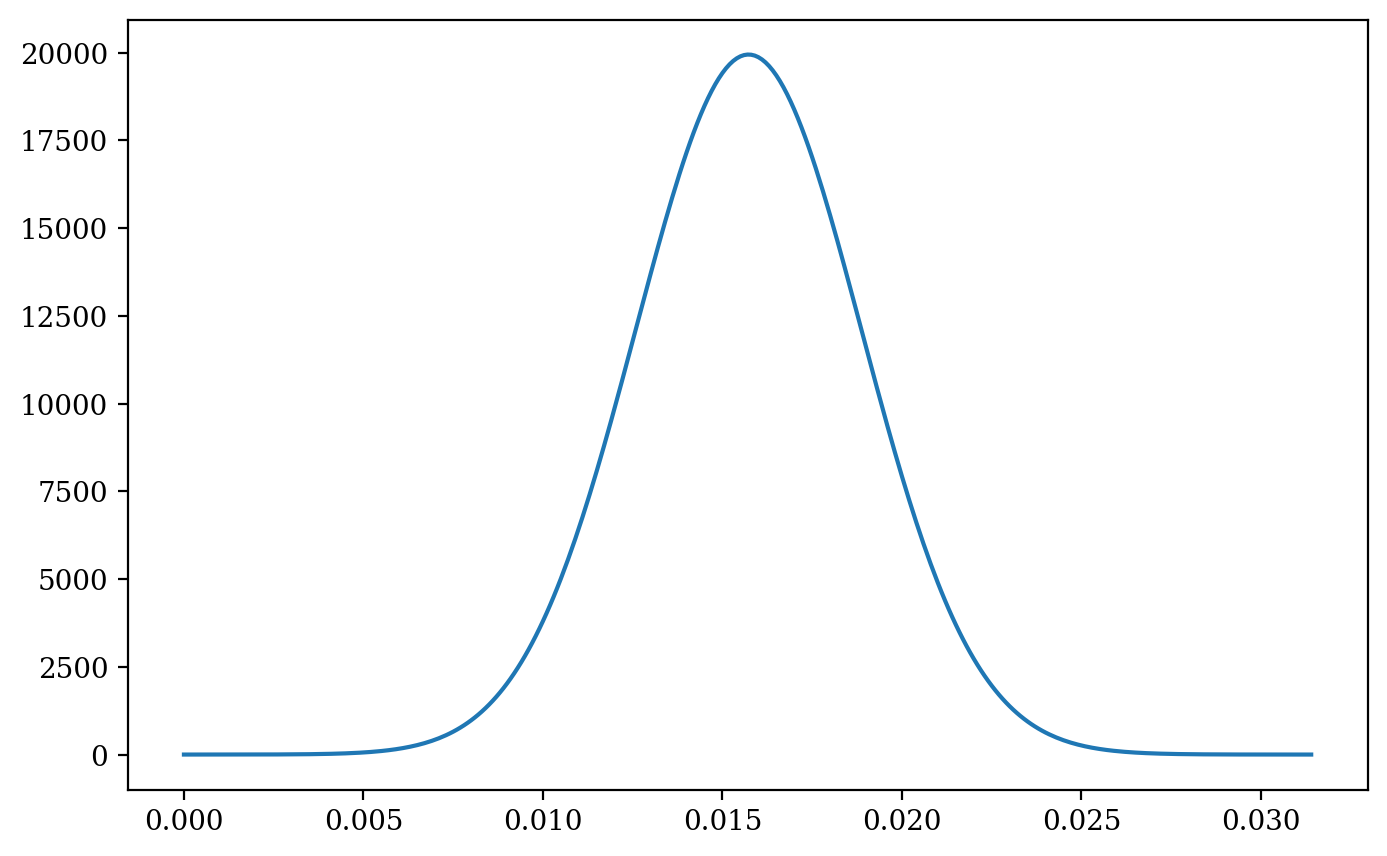

In [20]:
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, VBF(tbtest,tBraggPi*5,tBraggPi))
l.info(f"max(V) {1j*(dt/hb)*VBF(tBraggCenter,tBraggPi*5,tBraggPi)}")

In [21]:
V(tBraggCenter)

805491.077903538

In [22]:
VBF(tBraggCenter,tBraggPi*5,tBraggPi)

19947.114020071636

In [23]:
np.trapz(V(tbtest),tbtest) # this should be V0

6350.776181415861

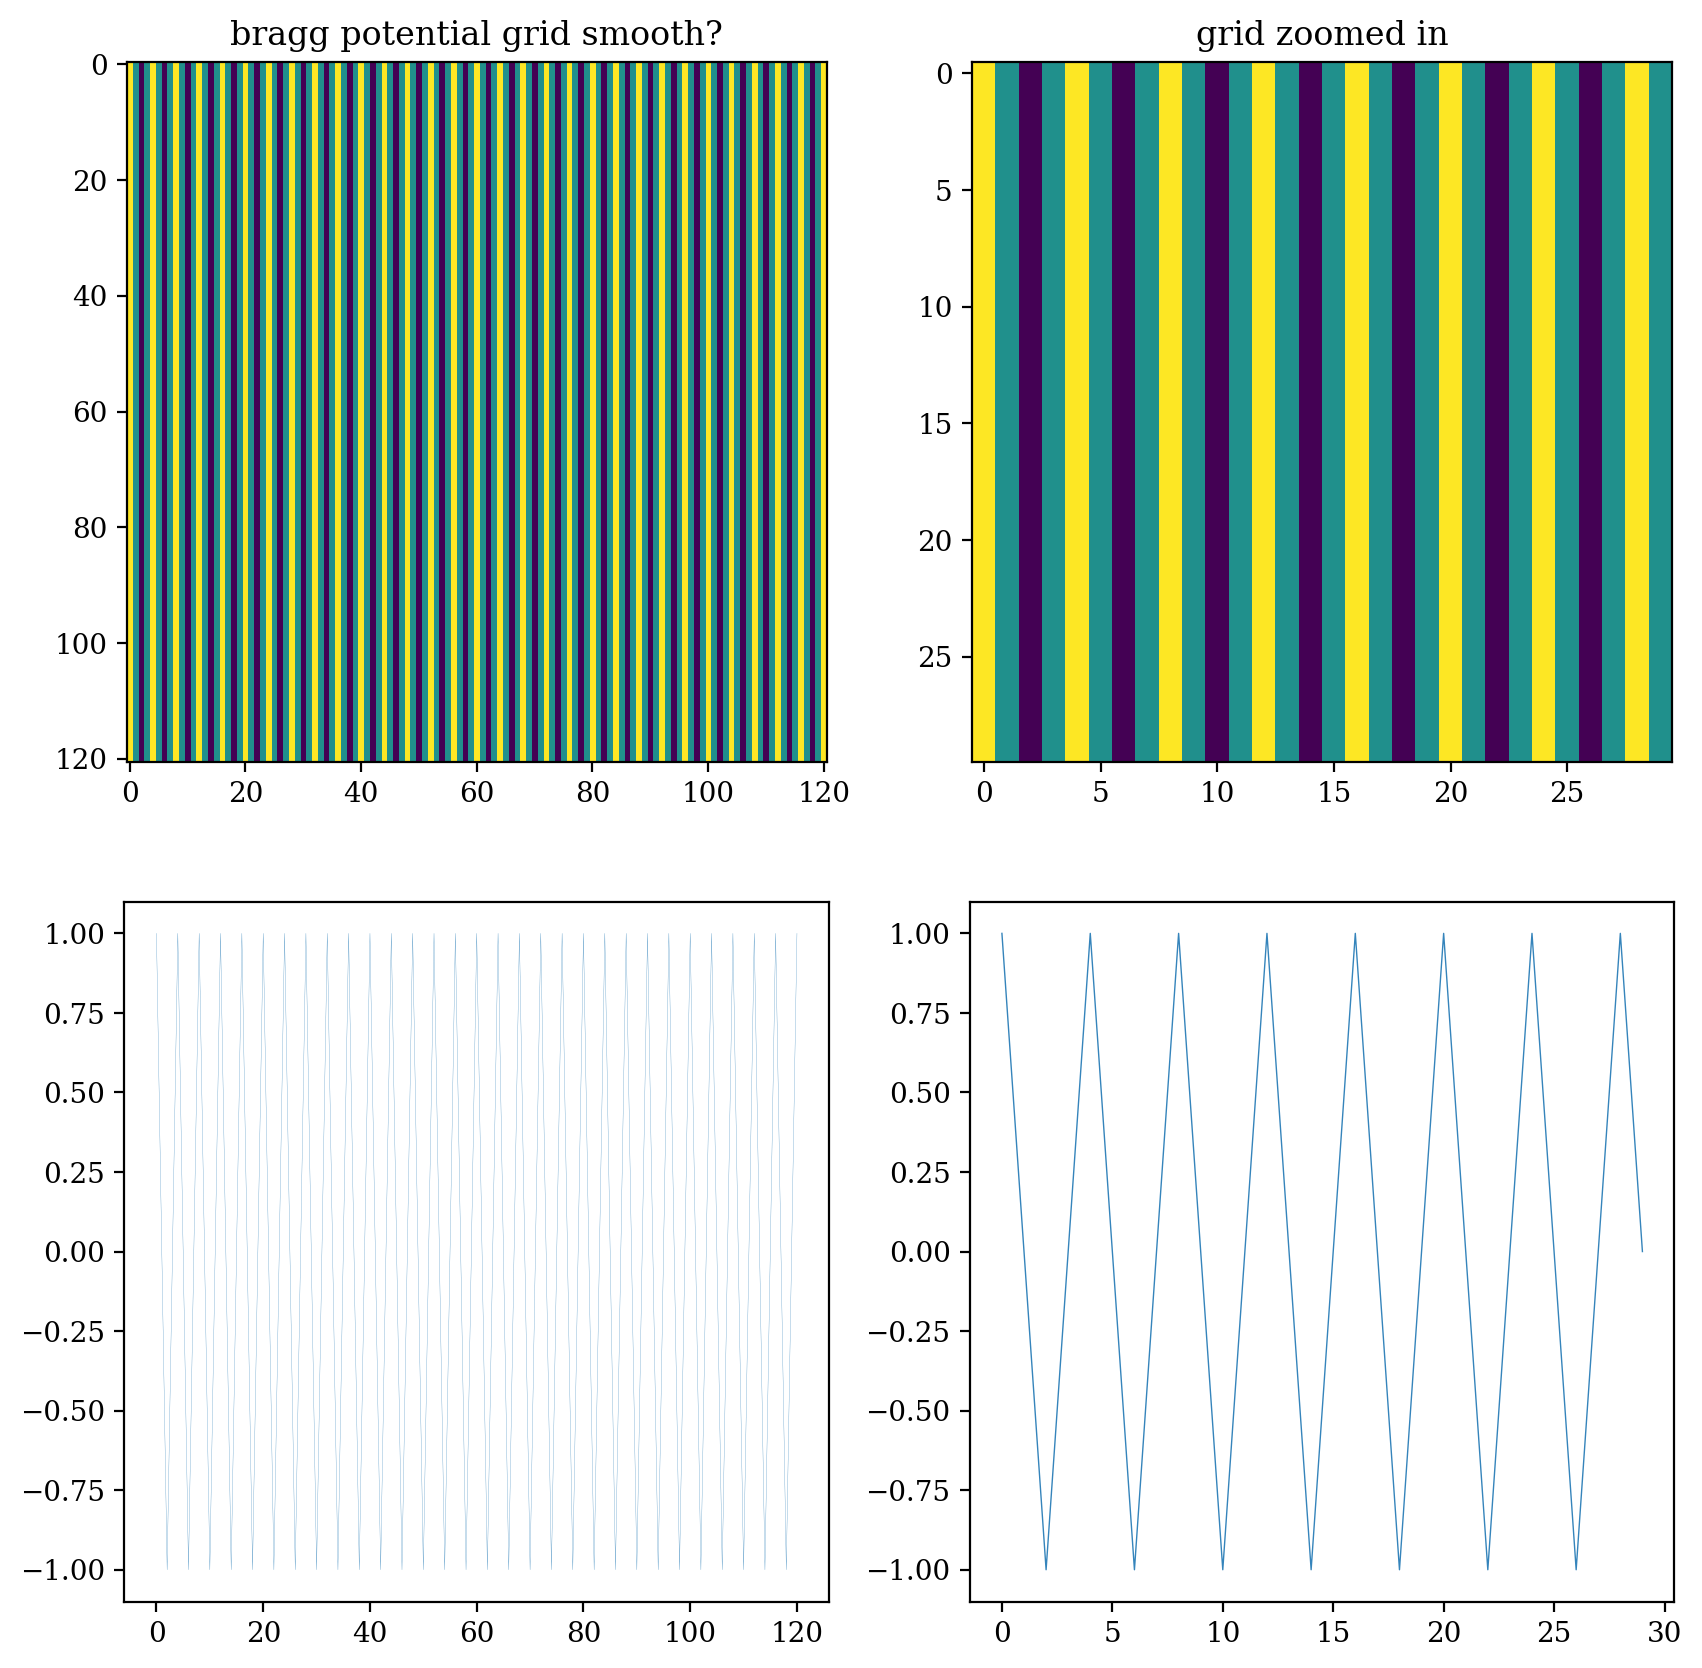

In [24]:
ncrop = 30
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(cosGrid.T,aspect=1)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosGrid[:ncrop,:ncrop].T,aspect=1)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosGrid[:,0],alpha=0.9,linewidth=0.1)

plt.subplot(2,2,4)
plt.plot(cosGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()

In [25]:
def plot_psi(psi, plt_show=True):
    """Plots $\psi$ of position wavefunction

    Args:
        psi (ndarray 2d): wavefunction dtype=complex
    """    
    
    plt.figure(figsize=(12, 4))
    extent = np.array([-xmax, +xmax, -zmax, +zmax])
    plt.subplot(1, 3, 1)
    plt.imshow(np.abs(psi.T)**2, extent=extent, interpolation='none')
    plt.ylabel("$z$ (µm)")
    plt.xlabel("$x$ (µm)")
    plt.title("Position $|\psi|^2$")
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.real(psi.T), extent=extent, interpolation='none')
    plt.xlabel("$x$ (µm)")
    plt.title("$\mathrm{Re}(\psi)$")
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.imag(psi.T), extent=extent, interpolation='none')
    plt.xlabel("$x$ (µm)")
    plt.title("$\mathrm{Im}(\psi)$")
    
    if plt_show: plt.show()

In [26]:
def plot_mom(psi, zoom_div2=15, zoom_div3=6, plt_show=True):
    """Plots momentum wavefunction

    Args:
        psi (ndarray 2d): complex position wavefunction
    """    
    
    
    plt.figure(figsize=(12,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])/(hb*k)
#     psifft = np.fft.fftshift(np.fft.fft2(psi))
    psifft = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
    psiAbsSqUnNorm = np.abs(psifft)**2
    swnf = sqrt(np.sum(psiAbsSqUnNorm)*dpx*dpz)
    psiAbsSq = psiAbsSqUnNorm / swnf
#     print(np.sum(psiAbsSq)*dpx*dpz)
#     plotdata = np.flipud(psiAbsSq.T)
    plotdata = (psiAbsSq.T)
    
    plt.subplot(1,3,1)
    plt.imshow(plotdata,extent=extent, interpolation='none') 
    plt.ylabel("$p_z \ (\hbar k)$")
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.title("Momentum $|\phi|^2$")
    
    plt.subplot(1,3,2)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/zoom_div2)
    nz2 = int((nz-1)/zoom_div2)
    plotdata = (psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,
               extent=np.array([pxlin[nxm-nx2],pxlin[nxm+nx2],pzlin[nzm-nz2],pzlin[nzm+nz2]])/(hb*k),
               interpolation='none') 
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.title("zoomed in")
    
    
    plt.subplot(1,3,3)
#     nx3 = int((nx-1)/200)
#     nz3 = int((nz-1)/200)
#     plotdata = np.flipud(psiAbsSq[nxm-nx3:nxm+nx3,nzm-nz3:nzm+nz3].T)
#     plt.imshow(plotdata,extent=extent*0.01) 
# #     print(nx2,nz2,nx3,nz3)
#     nxm = int((nx-1)/2)
#     nzm = int((nz-1)/2)
    nx2 = int((nx-1)/zoom_div3)
#     nz2 = int((nz-1)/zoom_div3)
    
    plt.plot((pxlin[nxm-nx2:nxm+nx2])/(hb*k), np.trapz(psiAbsSq,axis=1)[nxm-nx2:nxm+nx2])
    plt.axvline(x= 0,color='r',alpha=0.2)
    plt.axvline(x=+2,color='r',alpha=0.2)
    plt.axvline(x=-2,color='r',alpha=0.2)
#     plt.axvline(x=+4,color='r',alpha=0.2)
#     plt.axvline(x=-4,color='r',alpha=0.2)
#     plt.xlabel("$p (u\cdot \mu m/ms)$")
#     plt.ylabel("$|\phi(p)|^2$")
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.title("integrated over $p_z$")
    
#     plt.savefig("output/"+title+".pdf", dpi = 300) 
#     plt.savefig("output/"+title+".png", dpi = 300) 
#     plt.show()
    
    if plt_show: plt.show()
        

In [27]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))
def psi0ringUnNorm(x,z,pr=p,mur=10,sg=sg):
#     return (pi**1.5 * sg * (1 + scipy.special.erf(mur/sg)))**-1 \
    return 1 \
            * np.exp(-0.5*( mur - np.sqrt(x**2 + z**2) )**2 / sg**2) \
            * np.exp(+(1j/hb) * (x**2 + z**2)**0.5 * pr)

In [28]:
# V00 = 50000
# dt=0.01
# VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * V00 * cosGrid )
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)
# print("(dpx,dpz) = ", (dpx, dpz))
if abs(dpx - (pxlin[1]-pxlin[0])) > 0.0001: l.error("AHHHHH px")
if abs(dpz - (pzlin[1]-pzlin[0])) > 0.0001: l.error("AHHHHH pz")
l.info(f"""dpx = {dpx} uµm/m
dpz = {dpz} """)


expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin[indx]**2 + pzlin**2))  

dpx = 9.975781896282493 uµm/m
dpz = 9.975781896282493 


In [29]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
def psi0ringNp(mur=1,sg=1,pr=p):
    psi = np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0ringUnNorm(x,zlin[1:-1],pr,mur,sg)
    norm = np.sum(np.abs(psi)**2)*dx*dz
    psi *= 1/sqrt(norm)
    return psi

Super weird normalisation factor, swnf = 29.92734568884748
0.9999999999999999 |phi|**2 normalisation check
1.0 |psi|**2 normalisation check


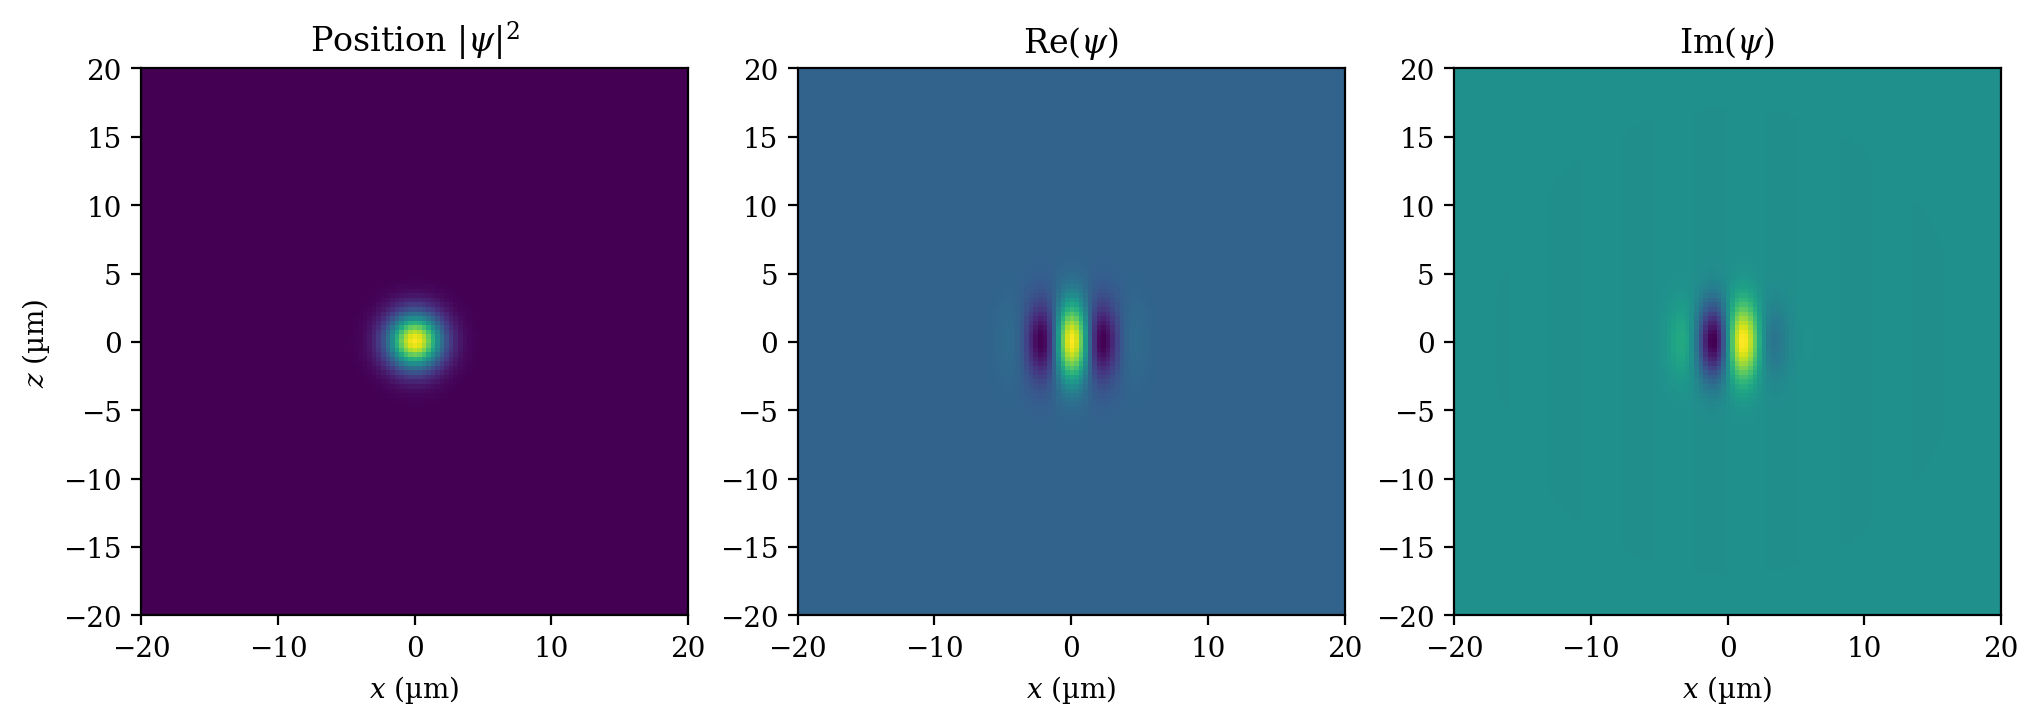

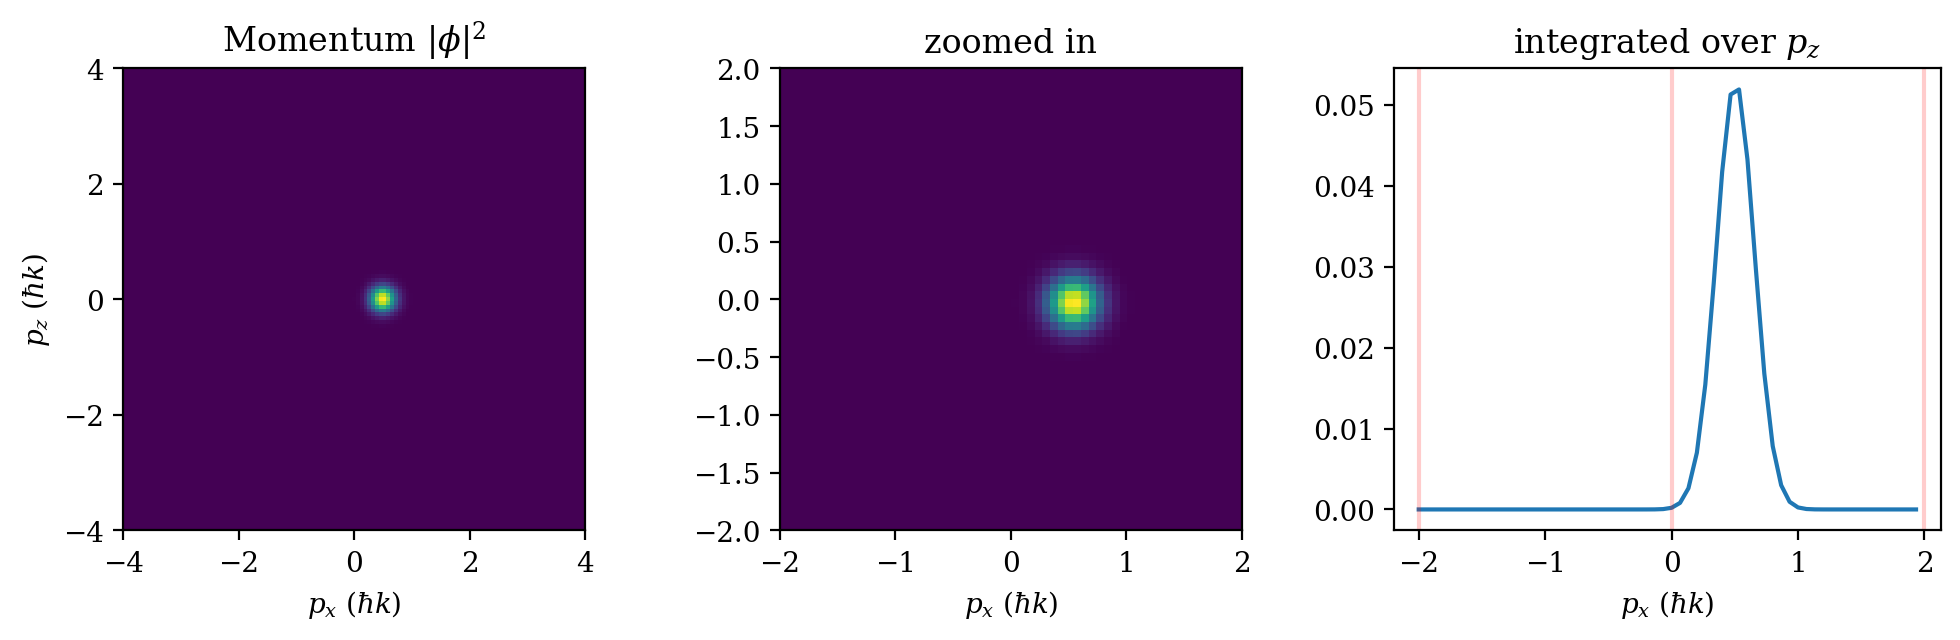

In [61]:
# psi = psi0np(5,5,0,0)
# psi = psi0np(5,5,-0.5*p,0)
# psi = psi0np(1,1,p,p)
# psi = psi0np(1,1,0,0)

def phiAndSWNF(psi):
    phiUN = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
    # superWeirdNormalisationFactorSq = np.trapz(np.trapz(np.abs(phiUN)**2, pxlin, axis=0), pzlin)
    superWeirdNormalisationFactorSq = np.sum(np.abs(phiUN)**2)*dpx*dpz
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return (swnf, phi)
    
psi = psi0ringNp(5,1.7,1*hb*k)
# psi = psi0np(2,2,0.5*p*np.cos(0),0.5*p*np.sin(0))
(swnf, phi) = phiAndSWNF(psi)

t = 0

print("Super weird normalisation factor, swnf =",swnf)
print(np.sum(np.abs(phi)**2)*dpx*dpz, "|phi|**2 normalisation check")
print(np.sum(np.abs(psi)**2)*dx*dz,   "|psi|**2 normalisation check")
plot_psi(psi,False)
title="init_ring_psi"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

plot_mom(psi,4,4,False)
title="init_ring_phi"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()


In [31]:
def toMomentum(psi, swnf):
    return np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swnf
def toPosition(phi, swnf):
    return pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi*swnf)),threads=nthreads,norm='ortho')

In [32]:
def plotNow(t, psi):
        print("time =", round(t*1000,4), "µs")
        print(np.sum(np.abs(psi)**2)*dx*dz,"|psi|^2")
        print(np.sum(np.abs(phi)**2)*dpx*dpz,"|phi|^2")
        plot_psi(psi)
        plot_mom(psi)

def numericalEvolve(
        t_init, 
        psi_init, 
        t_final, 
        tauPi  = tBraggPi, 
        tauMid = tBraggPi*5, 
        phase  = 0,
        doppd=dopd,
        print_every_t=-1, 
        final_plot=True,
        progress_bar=True, 
        V0FArg=V0F,
    ):
    assert (print_every_t > dt or print_every_t <= 0), "print_every_t cannot be smaller than dt"
    steps = ceil((t_final - t_init) / dt) 
    t = t_init
    psi = psi_init.copy()
    (swnf, phi) = phiAndSWNF(psi)
    
#     tauMid = tauPi * 5
#     tauEnd = tauPi * 10

    def loop():
        nonlocal t
        nonlocal psi
        nonlocal phi
        cosGrid = np.cos(2*k*xgrid + doppd*(t-tBraggCenter) + phase)
        VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tauMid,tauPi,V0FArg) * cosGrid )
        psi *= VxExpGrid
        phi = toMomentum(psi,swnf)
        phi *= expPGrid
        psi = toPosition(phi,swnf)
        psi *= VxExpGrid
        
        if print_every_t > 0 and step % round(print_every_t / dt) == 0: 
            plotNow(t,psi)
        t += dt 
        
    if progress_bar:
        for step in tqdm(range(steps)):
            loop()
    else:
        for step in range(steps):
            loop()
    
    if final_plot:
        print("ALL DONE")
        plotNow(t,psi)
    return (t,psi,phi)

In [33]:
_ = numericalEvolve(0, psi0np(1,1,0,0), dt, final_plot=False, progress_bar=False)

In [34]:
def freeEvolve(
    t_init,
    psi,
    t_final,
    final_plot=True,
    logging=False,
    ):
    Dt = t_final-t_init
    
    (swnf, phi) = phiAndSWNF(psi)
    
    if logging: print("checking this value is small ", -(1j/hb) * (0.5/m3) * (Dt)*pxmax)
    expPGridLong = np.zeros((nx,nz),dtype=complex)
    for indx in range(nx):
        expPGridLong[indx, :] = np.exp(-(1j/hb) * (0.5/m3) * (Dt) * (pxlin[indx]**2 + pzlin**2)) 
    
    phi *= expPGridLong
    psi = toPosition(phi,swnf)
    
    if final_plot:
        plotNow(t_final,psi)
        
    return (t_final, psi, phi)

In [35]:
_ = freeEvolve(0,psi0np(1,1,0,0),0.1,final_plot=False,logging=True)

checking this value is small  -0.15707963267948968j


In [36]:
(tBraggCenter,tBraggEnd,tBraggPi)

(0.01572701874067948, 0.03145403748135896, 0.0031454037481358954)

In [37]:
# short test run
_ = numericalEvolve(0, psi0np(3,3,0.5*p,0), 2*dt,progress_bar=False,final_plot=False)

In [77]:
def scanTauPiInnerEval(tPi, logging=True, progress_bar=True, ang=0, pmom=p, doppd=dopd, V0FArg=V0F):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    output = numericalEvolve(0, psi0np(2,2,pmom*np.cos(ang),pmom*np.sin(ang)), 
                             tauEnd, tauPi, tauMid, doppd=doppd, 
                             final_plot=logging,progress_bar=progress_bar,
                             V0FArg=V0FArg,
                            )
#     if pbar != None: pbar.update(1)
    return output

In [115]:
tPiTest = np.append(np.arange(0.05,0,-5*dt), 0) # note this is decending
    # tPiTest = np.arange(dt,3*dt,dt)
    
tPiOutput = Parallel(n_jobs=N_JOBS)(
    delayed(lambda i: (i, scanTauPiInnerEval(i, False, False,0,p,0*dopd,0.4*V0F)[:2]) )(i) 
    for i in tqdm(tPiTest)
)   

  0%|          | 0/101 [00:00<?, ?it/s]

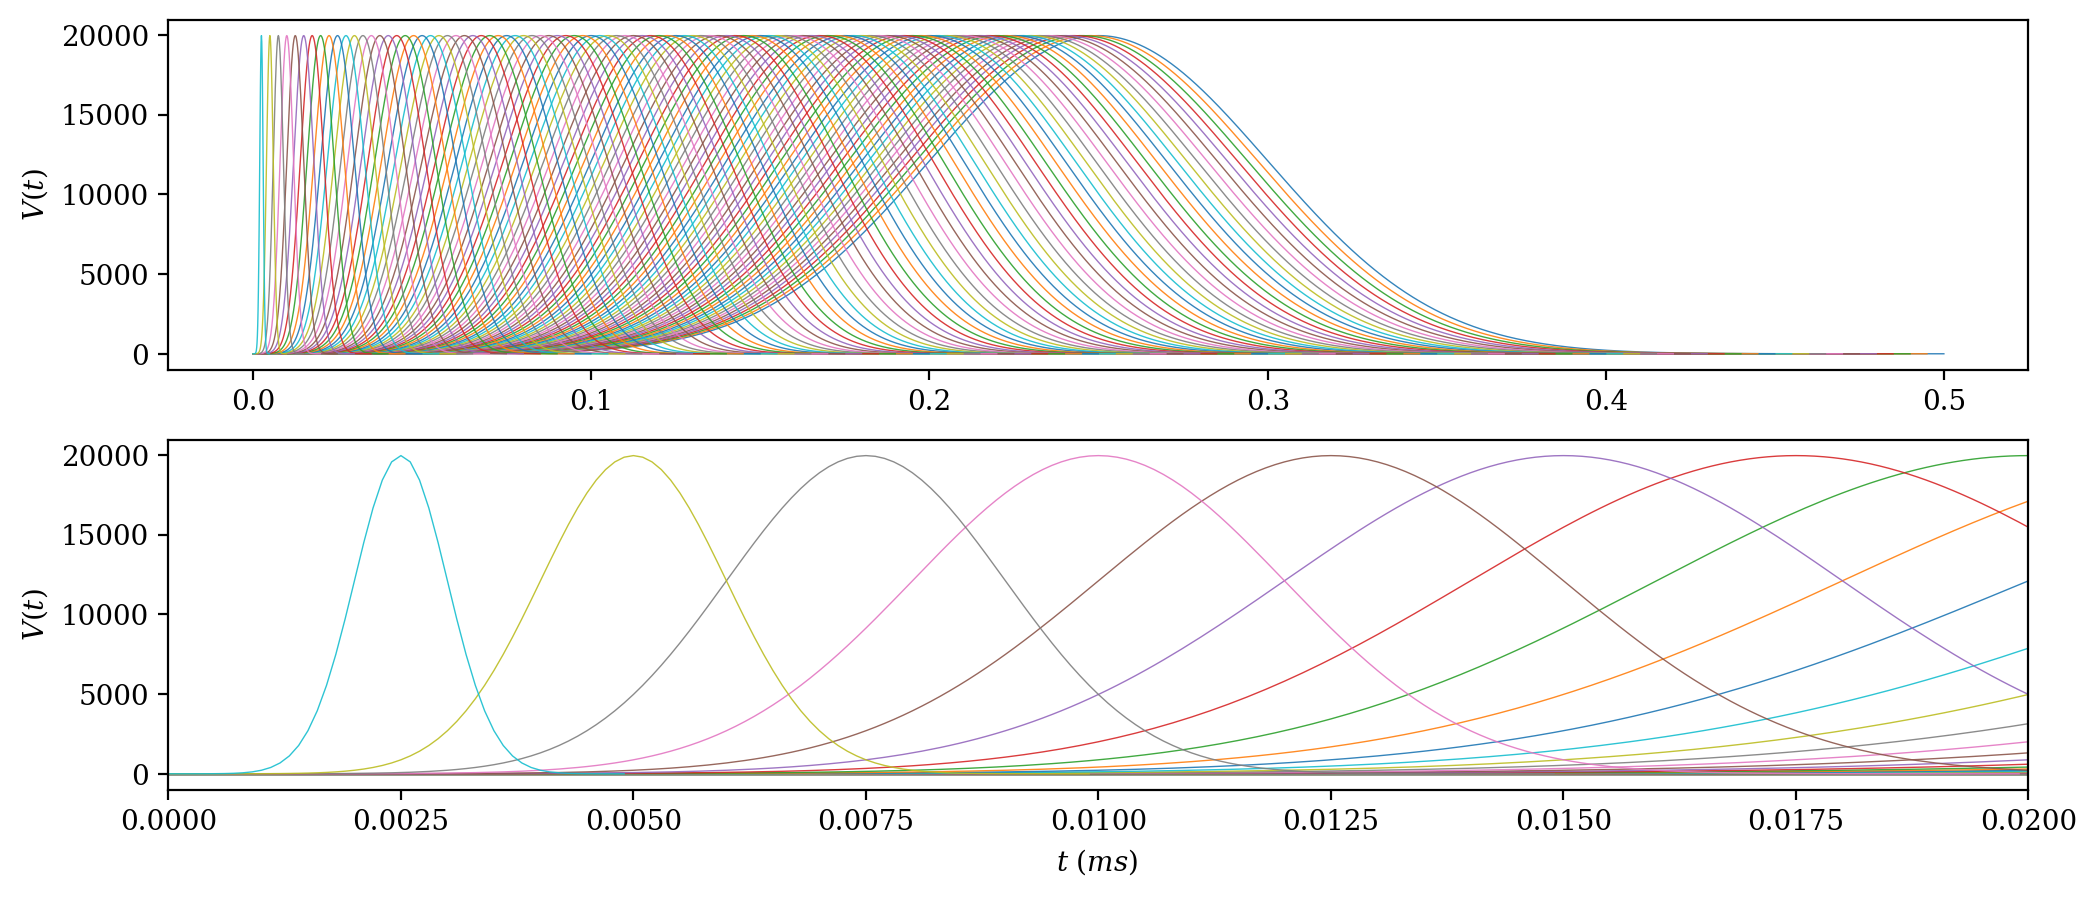

In [116]:
plt.figure(figsize=(12,5))
def plot_inner_helper():
    for (i, tauPi) in enumerate(tPiTest):
        if tauPi == 0: continue
        tauMid = tauPi * 5 
        tauEnd = tauPi * 10 
        tlinspace = np.arange(0,tauEnd,dt)
        plt.plot(tlinspace, VBF(tlinspace, tauMid, tauPi),
                 linewidth=0.5,alpha=0.9
            )
plt.subplot(2,1,1)
plot_inner_helper()
plt.ylabel("$V(t)$")

plt.subplot(2,1,2)
plot_inner_helper()
plt.xlim([0,0.02])
plt.xlabel("$t \ (ms)$ ")
plt.ylabel("$V(t)$")


title="bragg_strength_V0"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()

In [179]:
hbar_k_transfers = np.arange(-6,6+1)
pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
cut_p_width = 0.2
for (j, hbar_k) in enumerate(hbar_k_transfers):
    pzlinIndexSet[j] = abs(pxlin/(hb*k) - hbar_k) <= cut_p_width
    # print(i,hbar_k)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [180]:
phiDensityGrid = np.zeros((len(tPiTest), pxlin.size))
phiDensityGrid_hbark = np.zeros((len(tPiTest),len(hbar_k_transfers)))

for i in tqdm(range(len(tPiTest))):
    item = tPiOutput[i]
    (swnf, phi) = phiAndSWNF(item[1][1])
    phiAbsSq = np.abs(phi)**2
    phiX = np.trapz(phiAbsSq, pzlin,axis=1)
    phiDensityGrid[i] = phiX

    for (j, hbar_k) in enumerate(hbar_k_transfers):
        index = pzlinIndexSet[j]
        phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])

  0%|          | 0/101 [00:00<?, ?it/s]

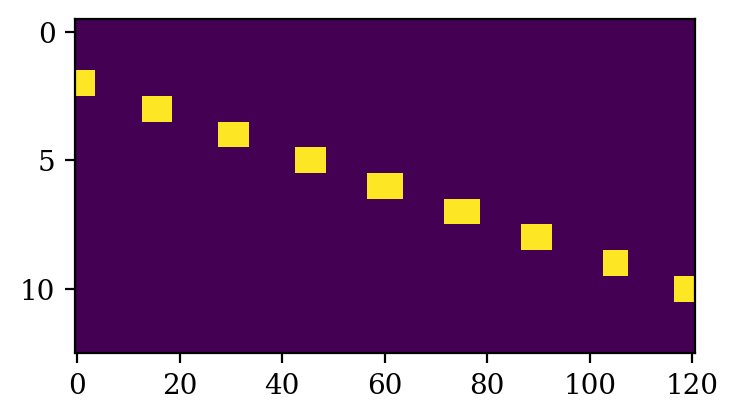

In [181]:
plt.figure(figsize=(4,4))
plt.imshow(pzlinIndexSet,interpolation='none',aspect=5)
# plt.axvline(x=1001, linewidth=1, alpha=0.7)

title="hbar_k_pxlin_integration_range"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

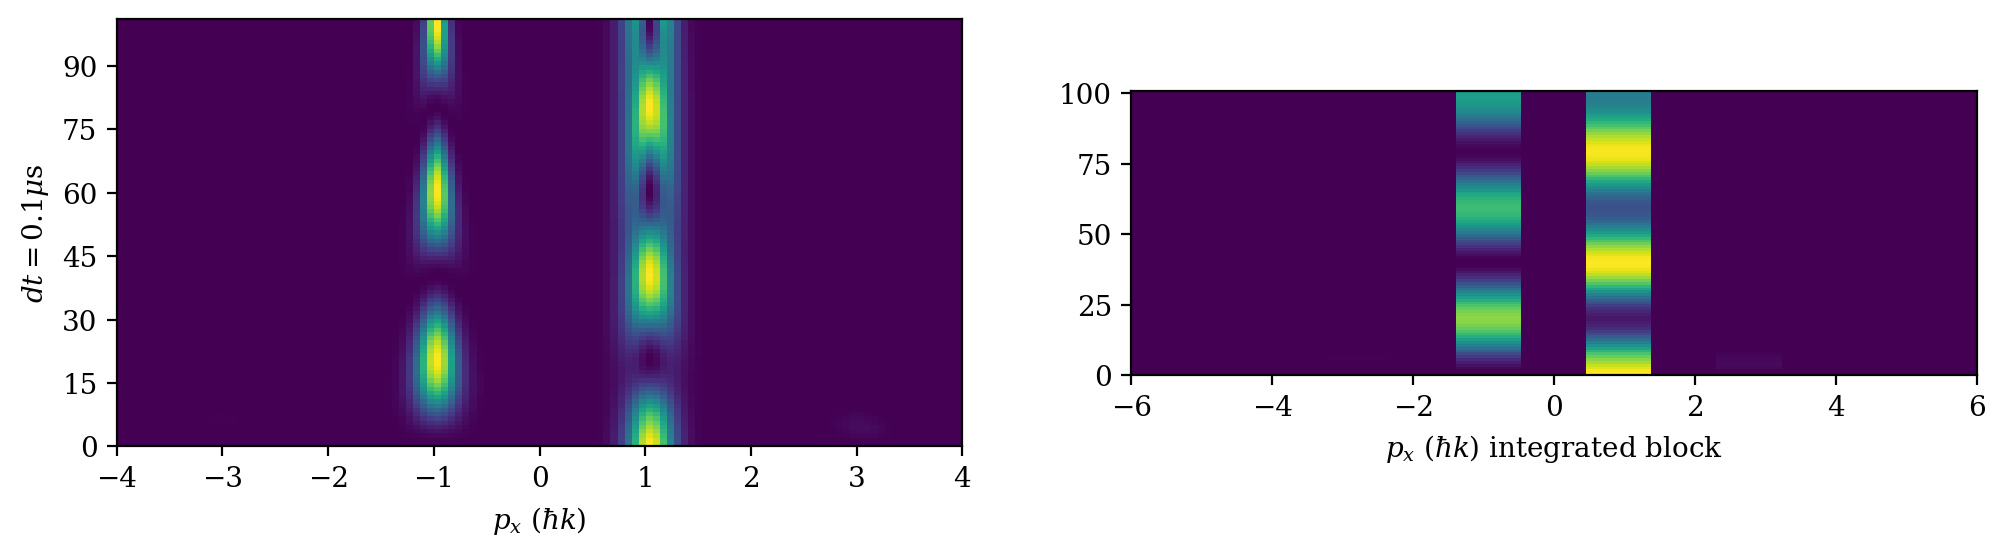

In [182]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

nxm = int((nx-1)/2)
nx2 = int((nx-1)/2)
plt.imshow(phiDensityGrid[:,nxm-nx2:nxm+nx2], 
           extent=[pxlin[nxm-nx2]/(hb*k),pxlin[nxm+nx2]/(hb*k),0,len(tPiTest)], 
           interpolation='none',aspect=0.04)
# plt.imshow(phiDensityGrid, 
#            extent=[-pxmax/(hb*k),pxmax/(hb*k),1,len(tPiTest)+1], 
#            interpolation='none',aspect=1)
# ax = plt.gca()
# for t in tPiTest:
#     plt.axhline(y=t/dt,color='white',alpha=1,linewidth=0.05,linestyle='-')
ax = plt.gca()
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.ylabel("$dt =$"+str(dt*1000) + "$\mu \mathrm{s}$")
plt.xlabel("$p_x \ (\hbar k)$")


plt.subplot(1,2,2)
plt.imshow(phiDensityGrid_hbark, 
           extent=[hbar_k_transfers[0],hbar_k_transfers[-1],0,len(tPiTest)], 
           interpolation='none',aspect=0.04)
plt.xlabel("$p_x \ (\hbar k)$ integrated block")

title="mom_dist_at_diff_angle"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [183]:
phiDensityNormFactor = np.trapz(phiDensityGrid_hbark)

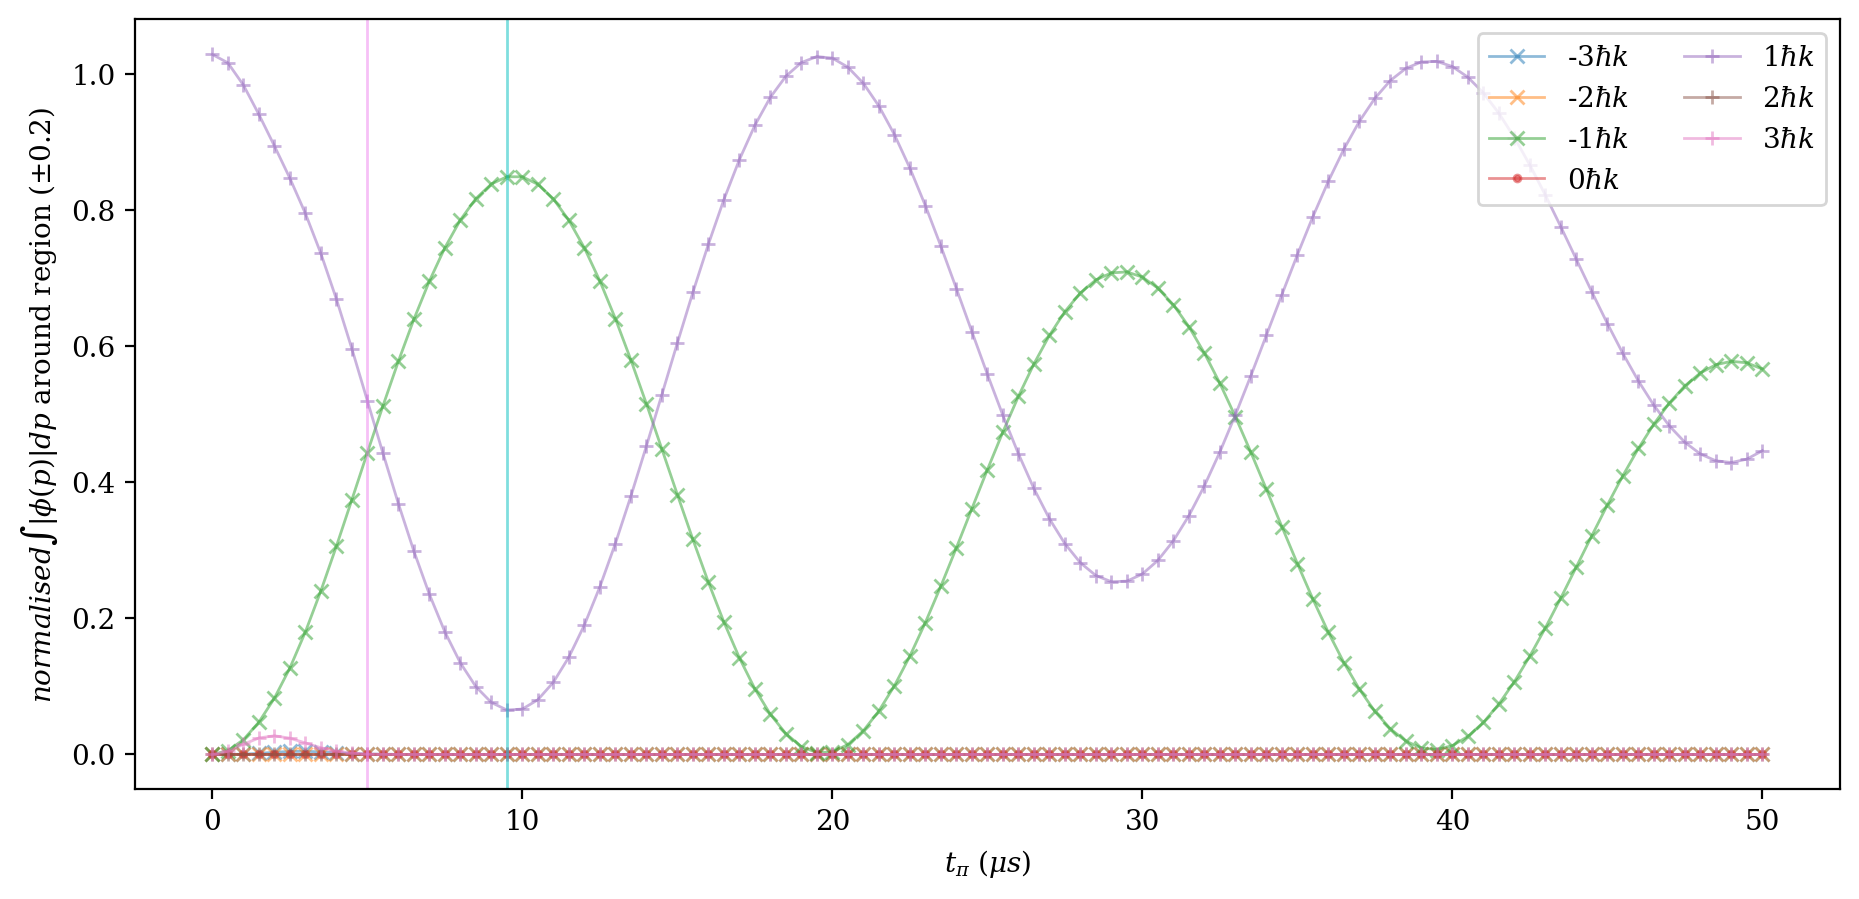

In [184]:
plt.figure(figsize=(11,5))
for (i, hbar_k) in enumerate(hbar_k_transfers):
    if abs(hbar_k) >3: continue
    if   hbar_k > 0: style = '+-'
    elif hbar_k < 0: style = 'x-'
    else:            style = '.-'
    plt.plot(tPiTest*1000, phiDensityGrid_hbark[:,i]/phiDensityNormFactor[i],
             style, linewidth=1,alpha=0.5, markersize=5,
             label=str(hbar_k)+"$\hbar k$",
            )

plt.legend(loc=1,ncols=2)
plt.ylabel("$normalised \int |\phi(p)| dp$ around region ($\pm$"+str(cut_p_width)+")")
plt.xlabel("$t_\pi \ (\mu s)$")
# plt.axhline(y=np.cos(pi  )**2,color='gray',linewidth=1,alpha=0.5)  # 2*pi pulse
# plt.axhline(y=np.cos(pi/2)**2,color='c',linewidth=1,alpha=0.5)     # pi   pulse
# plt.axhline(y=np.cos(pi/4)**2,color='violet',linewidth=1,alpha=0.5) # pi/2 pulse
# plt.axhline(y=np.cos(pi/8)**2,color='orange',linewidth=1,alpha=0.5)# pi/4 pulse

plt.axvline(x=tPiTest[81]*1000,color='c',linewidth=1,alpha=0.5)      # pi   pulse
plt.axvline(x=tPiTest[90]*1000,color='violet',linewidth=1,alpha=0.5) # pi/2 pulse
# plt.axvline(x= 9*dt*1000,color='orange',linewidth=1,alpha=0.5)  # pi/4 pulse

# plt.text((1+39)*dt*1000, 1, "$\pi$",color='c')
# plt.text((1+21)*dt*1000, 1, "$\pi/2$",color='violet')
# plt.text((1+ 9)*dt*1000, 1, "$\pi/4$",color='orange')

title = "bragg_pulse_duration_test_labeled"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()